# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-t16j0doh
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-t16j0doh
  Resolved https://github.com/albumentations-team/albumentations to commit 82818a0c4a80924d9f903a656c7f549ec6ca9cb2
  Preparing metadata (setup.py) ... done


# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

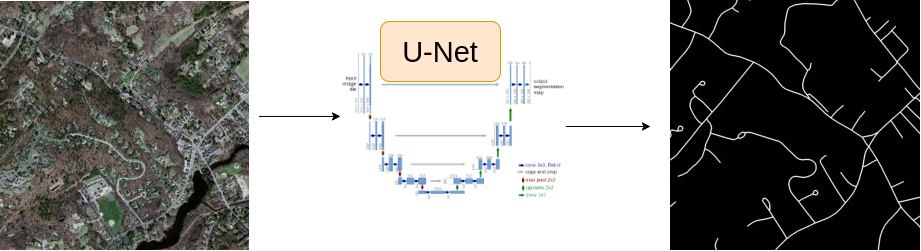

# Download Subset Dataset

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

fatal: destination path 'Road_seg_dataset' already exists and is not an empty directory.


# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE ='/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

#DEVICE = 'cuda'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 15
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [7]:
idx = 2

row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

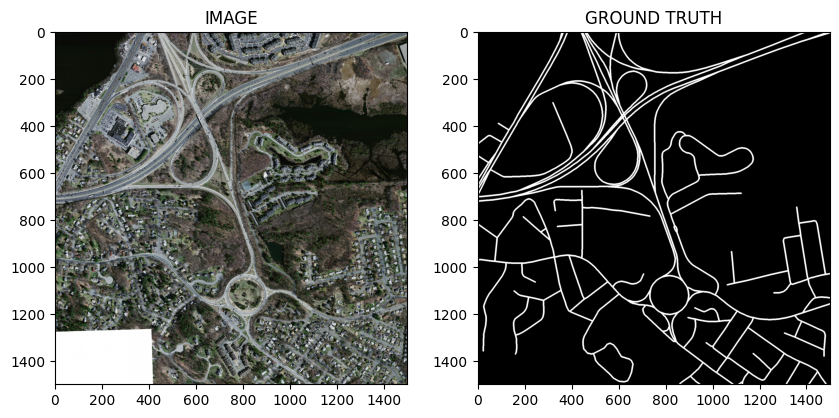

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

In [10]:
len(train_df)

159

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [11]:
import albumentations as A

In [12]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
    ])

# Task 4 : Create Custom Dataset

In [13]:
from torch.utils.data import Dataset

In [14]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  #(h, w)
    mask = np.expand_dims(mask, axis = -1) #(h, w, c)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32) #(c, h, w)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32) #(c, h, w)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [15]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [16]:
print(f'Size of trainset : {len(trainset)}')
print(f'Size of validset : {len(validset)}')

Size of trainset : 159
Size of validset : 40


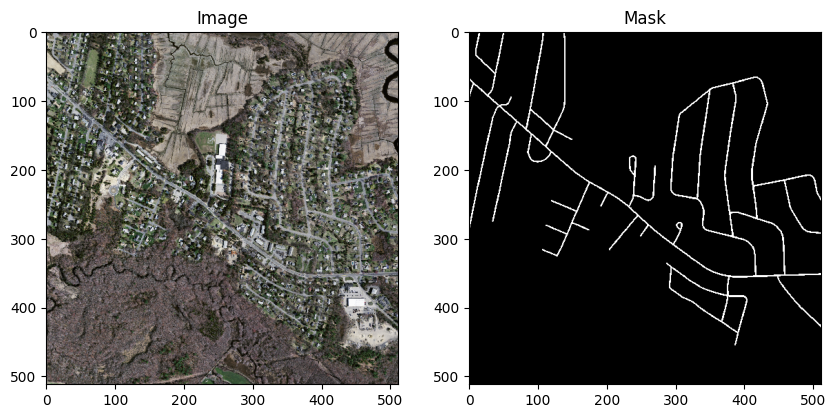

In [17]:
idx = 21
image, mask = trainset[idx]
def show_image(image, mask):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(np.transpose(image.numpy(), (1, 2, 0)))
    axes[0].set_title('Image')

    axes[1].imshow(np.transpose(mask.numpy(), (1, 2, 0)).squeeze(), cmap='gray')
    axes[1].set_title('Mask')

    plt.show()
show_image(image, mask)

# Task 5 : Load dataset into batches

In [18]:
from torch.utils.data import DataLoader

In [19]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [20]:
print(f'Total no. of batches in trainsloader : {len(trainloader)}')
print(f'Total no. of batches in validloader : {len(validloader)}')

Total no. of batches in trainsloader : 20
Total no. of batches in validloader : 5


In [21]:
for images, masks in trainloader:
  print(f"One batch image shape :  {images.shape}")
  print(f"One batch mask shape : {masks.shape}")
  break;

One batch image shape :  torch.Size([8, 3, 512, 512])
One batch mask shape : torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [22]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [23]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)
    return logits

In [24]:
model = SegmentationModel()
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

# Task 7 : Create Train and Validation Function

In [25]:
def train_fn(dataloader, model, optimizer):

  model.train() #Trun ON droupout, batchnorm, etc..

  total_loss = 0.0

  for images, masks in tqdm(dataloader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [26]:
def eval_fn(dataloader, model):

  model.eval() #Trun OFF droupout, batchnorm, etc..

  total_loss = 0.0

  with torch.no_grad():

    for images, masks in tqdm(dataloader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()

    return total_loss / len(dataloader)

# Task 8 : Train Model

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [29]:
print(torch.cuda.is_available())

False


In [ ]:
best_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), "best-model.pt")
    print("SAVED-MODEL")
    best_loss = valid_loss

  print(f"Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}")

100%|██████████| 5/5 [00:21<00:00,  4.39s/it]


SAVED-MODEL
Epoch : 1 Train Loss : 1.0894858151674272 Valid Loss : 1.0620906352996826


100%|██████████| 5/5 [00:21<00:00,  4.25s/it]


SAVED-MODEL
Epoch : 2 Train Loss : 0.7751070320606231 Valid Loss : 0.8362625479698181


 10%|█         | 2/20 [00:35<05:17, 17.64s/it]

# Task 9 : Inference

In [ ]:
idx = 17
model.load_state_dict(torch.load('/content/best-model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c, h, w) -> (b, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya

